# COCO Stop Sign Dataset
Steps to download COCO train, test, val dataset using fifty one library
https://cocodataset.org/#download

In [2]:
import os
if not os.path.exists("dataset"): 
    os.mkdir("dataset")

In [3]:
import fiftyone.zoo as foz
import fiftyone as fo

In [4]:
fo.config.dataset_zoo_dir = "/dataset"

In [4]:
# Downloading coco dataset
# Referenced from https://medium.com/voxel51/the-coco-dataset-best-practices-for-downloading-visualization-and-evaluation-68a3d7e97fb7

train_dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    label_types=["segmentations"],
    classes=["stop sign"],
    max_samples=400,
)

test_dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="test",
    label_types=["segmentations"],
    classes=["stop sign"],
    max_samples=50,
)


val_dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["segmentations"],
    classes=["stop sign"],
    max_samples=50,
)


 100% |██████|    1.9Gb/1.9Gb [2.1m elapsed, 0s remaining, 16.5Mb/s]      
Extracting annotations to '/dataset/coco-2017/raw/instances_train2017.json'
 100% |██████████████████| 400/400 [23.2s elapsed, 0s remaining, 12.9 images/s]      
Writing annotations for 400 downloaded samples to '/dataset/coco-2017/train/labels.json'
Dataset info written to '/dataset/coco-2017/info.json'
Loading 'coco-2017' split 'train'
 100% |█████████████████| 400/400 [7.4s elapsed, 0s remaining, 57.2 samples/s]       
Dataset 'coco-2017-train-400' created
Test split is unlabeled; ignoring classes requirement
Found test info at '/dataset/coco-2017/raw/image_info_test2017.json'
Sufficient images already downloaded
Existing download of split 'test' is sufficient
Loading 'coco-2017' split 'test'
Dataset is unlabeled; ignoring classes requirement
 100% |███████████████████| 50/50 [59.0ms elapsed, 0s remaining, 847.5 samples/s]  
Dataset 'coco-2017-test-50' created
Found annotations at '/dataset/coco-2017/raw/inst

In [8]:
from collections import defaultdict
import json
import numpy as np

# Referenced from https://machinelearningspace.com/coco-dataset-a-step-by-step-guide-to-loading-and-visualizing/
class COCOParser:
    def __init__(self, anns_file, imgs_dir):
        with open(anns_file, 'r') as f:
            coco = json.load(f)
            
        self.annIm_dict = defaultdict(list)        
        self.cat_dict = {} 
        self.annId_dict = {}
        self.im_dict = {}
        self.licenses_dict = {}
        for ann in coco['annotations']:           
            self.annIm_dict[ann['image_id']].append(ann) 
            self.annId_dict[ann['id']]=ann
        for img in coco['images']:
            self.im_dict[img['id']] = img
        for cat in coco['categories']:
            self.cat_dict[cat['id']] = cat
        for license in coco['licenses']:
            self.licenses_dict[license['id']] = license
    def get_imgIds(self):
        return list(self.im_dict.keys())
    def get_annIds(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann['id'] for im_id in im_ids for ann in self.annIm_dict[im_id]]
    def load_anns(self, ann_ids):
        im_ids=ann_ids if isinstance(ann_ids, list) else [ann_ids]
        return [self.annId_dict[ann_id] for ann_id in ann_ids]        
    def load_cats(self, class_ids):
        class_ids=class_ids if isinstance(class_ids, list) else [class_ids]
        return [self.cat_dict[class_id] for class_id in class_ids]
    def get_imgLicenses(self,im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        lic_ids = [self.im_dict[im_id]["license"] for im_id in im_ids]
        return [self.licenses_dict[lic_id] for lic_id in lic_ids]

In [9]:
anns_file = "/dataset/coco-2017/validation/labels.json"
imgs_dir = "/dataset/coco-2017/validation/data"
masks_dir = "/root/18794/18794_RoadVision/dataset/coco-2017/validation/masks"

parser = COCOParser(anns_file, imgs_dir)

In [76]:
len(parser.im_dict)

50

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import os

stop_sign_category = 13

# Referenced from ChatGPT

def visualize_with_mask(parser, img_id, imgs_dir, masks_dir, save):
    # Load image metadata
    img_info = parser.im_dict[img_id]
    img_path = os.path.join(imgs_dir, img_info['file_name'])
    
    # Open the image
    # img = Image.open(img_path).convert("RGB")
    # # Prepare to draw segmentation masks
    # draw = ImageDraw.Draw(img, "RGBA")

    with Image.open(img_path) as img:
        width, height = img.size

    # Create a blank binary mask image
    mask = Image.new("1", (width, height), 0)  # Mode "1" for binary (1-bit)
    draw = ImageDraw.Draw(mask)

    # draw = ImageDraw.Draw(img)

    
    # Load annotations for the image
    ann_ids = parser.get_annIds([img_id])
    anns = parser.load_anns(ann_ids)
    
    for ann in anns:
        if ann['category_id'] == stop_sign_category and 'segmentation' in ann:
            for seg in ann['segmentation']:
                # Convert segmentation points into pairs
                polygon = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                
                # Draw mask with transparency (e.g., red mask)
                draw.polygon(polygon, fill=1)  #(0,255,0, 100) # Green with 40% opacity
                
    # Display the result
    # plt.figure(figsize=(10, 10))
    # plt.imshow(img)
    plt.imshow(np.array(mask), cmap="gray")
    plt.axis("off")
    print(img_info["file_name"])
    print("IMAGE:", width, height)
    print("MASK:", np.array(mask).shape)
    if not save:
        plt.show()
    else:
        # plt.savefig("mask.png", bbox_inches='tight', pad_inches=0)
        mask = mask.convert("L")  # Convert to grayscale for compatibility
        save_path = os.path.join(masks_dir, f"mask_{img_info['file_name']}")
        mask.save(save_path)
        # plt.savefig(, bbox_inches='tight', pad_inches=0, format="PNG")
        # print(os.path.join(masks_dir, f"mask_{img_info['file_name']}"))
    plt.clf()


In [57]:
img_ids = parser.get_imgIds()
visualize_with_mask(parser, img_id=img_ids[0], imgs_dir=imgs_dir, masks_dir=masks_dir, save=True)

000000297343.jpg
IMAGE: 640 432
MASK: (432, 640)


<Figure size 640x480 with 0 Axes>

In [58]:
from PIL import Image
import numpy as np
import cv2

# Load the image using Pillow
image = Image.open("/root/18794/18794_RoadVision/dataset/coco-2017/validation/masks/mask_000000297343.jpg")

# Convert the image to a NumPy array
image_array = np.array(image)
image_array.shape

(432, 640)

## Generate binary image segmentation masks

In [11]:
for ds_type in ["validation"]:
    anns_file = f"/dataset/coco-2017/{ds_type}/labels.json"
    imgs_dir = f"/dataset/coco-2017/{ds_type}/data"
    masks_dir = f"/root/18794/18794_RoadVision/dataset/coco-2017/{ds_type}/masks"

    parser = COCOParser(anns_file, imgs_dir)

    for id in parser.im_dict.keys():
        visualize_with_mask(parser, img_id=id, imgs_dir=imgs_dir, masks_dir=masks_dir, save=True)

    print(f"{ds_type} dataset completed")


000000297343.jpg
000000336587.jpg
000000122745.jpg
000000104782.jpg
000000000724.jpg
000000379800.jpg
000000334006.jpg
000000153568.jpg
000000214200.jpg
000000369751.jpg
000000100283.jpg
000000191471.jpg
000000011122.jpg
000000126592.jpg
000000127092.jpg
000000100723.jpg
000000381971.jpg
000000369442.jpg
000000213593.jpg
000000252332.jpg
000000261888.jpg
000000375493.jpg
000000196754.jpg
000000091619.jpg
000000232646.jpg
000000192716.jpg
000000335177.jpg
000000307074.jpg
000000283038.jpg
000000343496.jpg
000000082846.jpg
000000333697.jpg
000000361506.jpg
000000172856.jpg
000000184324.jpg
000000212072.jpg
000000246963.jpg
000000225946.jpg
000000193884.jpg
000000273617.jpg
000000309173.jpg
000000088462.jpg
000000222094.jpg
000000347163.jpg
000000239843.jpg
000000104198.jpg
000000079408.jpg
000000095899.jpg
000000015440.jpg
000000245513.jpg
validation dataset completed


<Figure size 640x480 with 0 Axes>

In [30]:
from PIL import Image
import numpy as np
import cv2

# Load the image using Pillow
image = Image.open("/root/18794/18794_project/datasets/data/coco/train/data/000000000064.jpg")
mask = Image.open("/root/18794/18794_project/datasets/data/coco/train/masks/mask_000000000064.jpg")

# Convert the image to a NumPy array
image_array = np.array(image)
mask_array = np.array(mask)
height, width = image_array.shape[:2]
mask_resized = cv2.resize(mask_array, (width, height), interpolation=cv2.INTER_NEAREST)


# Display the size of the image
print("Image size (Height, Width, Channels):", image_array.shape)
print("Mask size (Height, Width, Channels):", mask_resized.shape)

# Overlay the mask on the image
# Normalize mask to range [0, 1] if not already
mask_resized = mask_resized / 255.0 if mask_resized.max() > 1 else mask_resized

# Apply the mask as an overlay with transparency
overlay = image_array.copy()


Image size (Height, Width, Channels): (640, 480, 3)
Mask size (Height, Width, Channels): (640, 480, 3)


In [34]:
overlay[mask_resized > 0] = 0

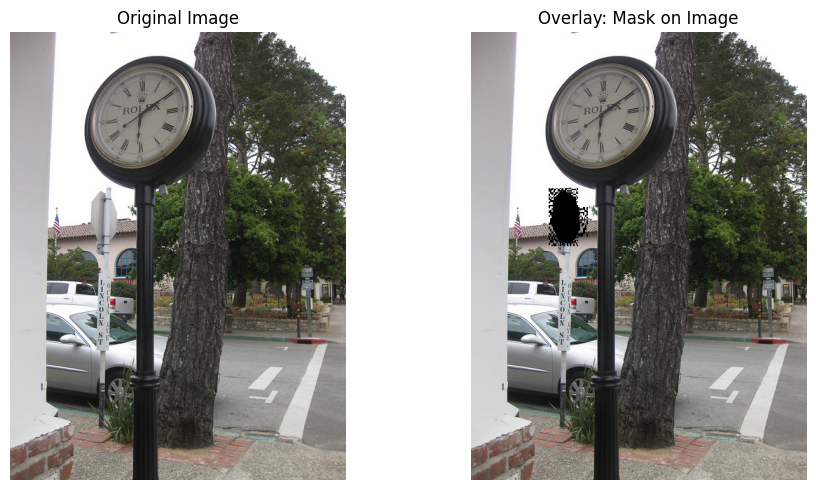

In [35]:

# overlay[mask_resized > 0] = [255,0,0]  # Make mask regions red

# Plot the result
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_array)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Overlay: Mask on Image")
plt.imshow(overlay)
plt.axis("off")

plt.tight_layout()
plt.show()
 